# CS421 Project Report

Done by: CHAN Yao Ying, CHEW Chong Jun, Christopher Harrison CHANG, Jennifer POERNOMO, Michelle LEONG Hwee-Ling, YUN Waddy Soe

## Importing libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Import datasets

dataset_path = "." # edit this to the desired path
data1 = np.load(f"{dataset_path}/first_batch.npz")
data2 = np.load(f"{dataset_path}/second_batch_with_labels.npz")
data3 = np.load(f"{dataset_path}/third_batch_with_labels.npz")
data4 = np.load(f"{dataset_path}/fourth_batch_with_labels.npz")

## Helper functions

> The `get_metrics` function has been updated slightly to replace it with the correct way of evaluating.

In [ ]:
# Helper function for Initial Pre-processing done by prof
def pre_process(data):
  X=data["X"]
  y=data["y"]

  XX=pd.DataFrame(X)
  yy=pd.DataFrame(y)
  XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
  yy.rename(columns={0:"user",1:"label"},inplace=True)
  #yy = yy.drop(columns=['user'])
  return XX, yy

# Helper function to convert dataset to an unsorted sparse matrix
def to_sparse_matrix(dataset):
  X_matrix = dataset.copy()
  X_matrix['rating'] = X_matrix['rating'] + 1
  X_matrix = X_matrix.pivot(index="user", columns="item", values="rating").fillna(0)
  return X_matrix

# Helper function to get metrics
def get_metrics(y_pred, y_test):
  rounded = []
  for p in y_pred:
    if p >= 0.5:
      rounded.append(1)
    else:
      rounded.append(0)
  result = {}
  avg = 'binary'
  result['AUC'] = metrics.roc_auc_score(y_test, y_pred)
  result['Precision'] = metrics.precision_score(y_test, rounded, average=avg)
  result['Recall'] = metrics.recall_score(y_test, rounded, average=avg)
  result['F1 Score'] = metrics.f1_score(y_test, rounded, average=avg)

  return result

# Helper function to create NN
def create_nn():
  nn = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
  return nn

# Helper function to train-test split dataset while ensuring that user interactions are contained within their dataset (either train or test)
def ttsplit(XX, yy, test_size=0.2, random_state=1):
    # Splits dataset by USER
    user_train, user_test, yy_train, yy_test = train_test_split(yy.user,yy.label,stratify=yy.label,test_size=test_size,random_state=random_state)

    # convert user labels to hashmaps
    yy_train_dict = yy_train.to_dict()
    yy_test_dict = yy_test.to_dict()

    # Ensures that all interactions by users in train set goes in train set & all interactions by users in validation set goes in validation
    XX_train = XX.loc[XX['user'].isin(user_train)]
    XX_test = XX.loc[XX['user'].isin(user_test)]

    user_train = {v: k for k, v in user_train.items()}
    user_test = {v: k for k, v in user_test.items()}

    yy_train = XX_train.copy().drop('item', axis=1).drop('rating', axis=1)
    yy_train['label'] = [yy_train_dict[user_train[n]] for n in yy_train['user'].to_numpy()]
    yy_train = yy_train.drop_duplicates().set_index('user').sort_index()
    print(f"{yy_train.shape}")

    yy_test = XX_test.copy().drop('item', axis=1).drop('rating', axis=1)
    yy_test['label'] = [yy_test_dict[user_test[n]] for n in yy_test['user'].to_numpy()]
    yy_test = yy_test.drop_duplicates().set_index('user').sort_index()
    print(f"{yy_test.shape}")
    
    return XX_train, XX_test, yy_train, yy_test

# Helper function to remove outlier data with NaN value
def remove_outlier(df):
  """
  We assume rating_std has the nan value
  """
  outlier = df[df.isna().any(axis=1)]
  outlier_index = outlier.index
  for index in outlier_index:
    df.at[index, 'rating_std'] = 0
    df.at[index, 'std_sq_rating_diff'] = 0
    df.at[index, 'std_rating_ratio'] = 0

## Week 9 (First and Second Batch)

In [ ]:
# Initial Pre-processing
X1, y1 = pre_process(data1)
X2, y2 = pre_process(data2)
y1 = y1.set_index('user')
y2 = y2.set_index('user')

### Applying models, train-test on batch 1 only

#### Convert First Batch to sparse matrix

For our first attempt in week 9, our first intuition was to convert the dataset into a **Sparse Matrix**, where the rows represent the users, the columns represent the items, and each cell contains the rating that the respective user gave to the item.

We thought that by converting each user into a vector of ratings, we may be able to represent them on a space and classify them by either supervised classifiers or clustering techniques.

As the ratings are from 0 - 5, we added +1 to the values of all the ratings so that the absence of a rating for a particular movie can be represented by a '0', while '1' through '6' represents the ratings of the movie.

In [ ]:
X_matrix = to_sparse_matrix(X1)
X_matrix[988] = 0.0  # We added this in as no users in the First Batch have rated this movie,
                     # while the Second Batch has users which rated this movie
                     # This ensures that both sparse matrices (First and Second Batch) have the same shape

X_matrix = X_matrix.reindex(sorted(X_matrix.columns), axis=1)
X_matrix

item,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5196,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5197,4.0,4.0,0.0,3.0,0.0,4.0,4.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Train-test split

Because we were first only given first batch with labels and the second batch without labels, we had to use a subset of the first batch as validation data. To do so, we created a train-test split where 20% of the data belongs to the validation set.

We use stratified split when splitting the data to preserve the proportions of anomalies and normal users in both datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y1, stratify=y1.label, test_size=0.2, random_state=1)
display(X_train, y_train)

item,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user,,,,,,,,,,,,,,,,,,,,,
905,5.0,3.0,0.0,0.0,0.0,5.0,4.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3247,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3932,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3466,5.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,label
user,
905,0
1275,0
3855,0
517,0
3530,0
...,...
3247,0
3932,0
3466,0


After doing a train test split, we decided to explore multiple different machine learning models as follows:

**Supervised Learning**
- Naive Bayes Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- Decision Tree Classifier
- Neural Network

**Unsupervised Learning**
- Gaussian Mixture Model
- K-Means Clustering

#### Applying Naive Bayes Classifier

For the Naive Bayes model, there were a few different variations we could could choose from. Complement Naive Bayes (CNB) classifier is a variation of the Multinomial Naive Bayes (MNB) classifier that performs better on imbalanced datasets. With knowledge that the dataset we are working with is an imbalanced one, CNB seems to be the better choice.

In [ ]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()

cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df1 = pd.DataFrame(result, index=["CNB"])
result_df1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
CNB,0.557,0.051829,0.425,0.092391


#### Applying Logistic Regression

We wanted to use Logistic Regression because we have only two classes. It is a simple classifier model that can serve as a baseline of the performance of our other models.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df2 = pd.DataFrame(result, index=["LR"])
result_df2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
LR,0.5765,0.145455,0.2,0.168421


Unfortunately, the performance of logistic regression is not satisfactory. We thought that it might be because the data is not linearly separable. Hence, we decided to attempt more complex models in hopes that they will be able to better model the relationship between the data.

#### Applying SVM

We decided to try SVM because SVM is found to be effective in high dimensional spaces, which suits our chosen method of representation as it had 1000 dimensions. SVM also offers different kernel functions that we decided to explore to see which can best classify our dataset.

In [ ]:
from sklearn import svm as SVM
svm = SVM.SVC(kernel='linear') 

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df3 = pd.DataFrame(result, index=["SVM"])
result_df3

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
SVM,0.605,0.144737,0.275,0.189655


Ultimately, we went with the linear kernel as it gave us the best AUC among the other SVM kernel functions. As evidenced by the results, it does indeed work better than Logistic Regression. However, the performance is still not spectacular.

#### Applying Decision Tree Classifier

We decided to try Decision Tree Classifier, which is a rule-based approach by using the dataset features to create yes/no questions and continually split the dataset until you isolate all data points belonging to each class.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy',random_state=5)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df4 = pd.DataFrame(result, index=["DTC"])
result_df4

,AUC,Precision,Recall,F1 Score
DTC,0.727,0.475,0.475,0.475


Among the machine learning models that we have tried so far, the Decision Tree Classifier gives the best AUC results.

#### Applying Neural Network

We decided to try Neural Network as well because we thought that it might be able to capture the underlying relationship of our data more accurately due to its non-linearity. Neural Networks are known to be good at modeling highly volatile data and fraud detection, which is aligned to the problem we are trying to solve.

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(420)

nn = create_nn()

nn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
nn.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
130/130 [==============================] - 4s 4ms/step - loss: 0.1628 - auc: 0.7672 - precision: 0.0588 - recall: 0.0063
Epoch 2/5
130/130 [==============================] - 0s 4ms/step - loss: 0.1068 - auc: 0.9192 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
130/130 [==============================] - 0s 4ms/step - loss: 0.0710 - auc: 0.9820 - precision: 0.8571 - recall: 0.1125
Epoch 4/5
130/130 [==============================] - 0s 4ms/step - loss: 0.0522 - auc: 0.9950 - precision: 0.9138 - recall: 0.3313
Epoch 5/5
130/130 [==============================] - 0s 4ms/step - loss: 0.0322 - auc: 0.9977 - precision: 0.9565 - recall: 0.6875


In [ ]:
y_pred = nn.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df5 = pd.DataFrame(result, index=["NN"])
result_df5

33/33 [==============================] - 0s 1ms/step


,AUC,Precision,Recall,F1 Score
NN,0.894825,0.75,0.075,0.136364


#### Applying KMeans Model

We also tried K-Means clustering because we hypothesised that the poor performance of GMM might be due to overfitting (i.e. it is learning the shape of the normal cluster).

Our methodology is as such:
1. Train the K-Means model on one giant cluster.
2. Find the euclidean distance of the all the points to the centroid of that cluster.
3. Determine a threshold of the distance from centroid where we will start classifying points as anomalies if it is beyond that distance.
4. Find the distances from the centroid of all points on the test data.
5. Classify points according to the scores - if the distance from the centroid is larger than the threshold, then the point is classified as an anomaly. If the distance is smaller than the threshold, then the point is classified as normal.

In [ ]:
# Imports
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing

# Scale Dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train Model
km = KMeans(n_clusters=1)
kmm = km.fit(X_train)

km_labels = kmm.labels_
km_center = kmm.cluster_centers_

# Function to Calculate Euclidean Distance from Centroid
def euclidean_dist(XX, center):
  to_return = []

  for row in XX:
    to_return.append(np.linalg.norm(row-center))

  return to_return

# Calculate distances
km_distances = euclidean_dist(X_train, km_center)

# Percentage of Anomalties on Dataset
km_percentile = (y_train['label'].value_counts(normalize=True) * 100)[0]
km_threshold = np.percentile(km_distances, km_percentile)

# Predict Labels
y_pred = y_test.copy()
y_pred['dist'] = euclidean_dist(X_test, km_center)
y_pred['predicted_label'] = y_pred['dist'].apply(lambda x: 1 if x >= km_threshold else 0)
y_pred = y_pred.drop('label', axis=1).drop('dist', axis=1)

result = get_metrics(y_pred.predicted_label.values, y_test)

result_df6= pd.DataFrame(result, index=["KMM"])
result_df6

,AUC,Precision,Recall,F1 Score
KMM,0.494,0.026316,0.025,0.025641


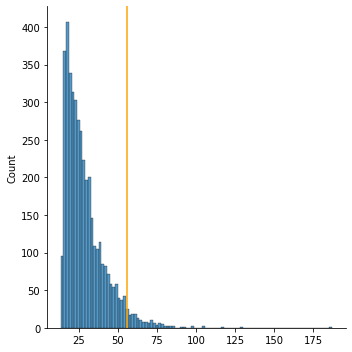

In [ ]:
# Display distribution of data points from center
sns.displot(km_distances, bins=100)
plt.axvline(x=km_threshold, color='orange')

Unfortunately, the AUC is not very satisfactory.

#### Applying Gaussian Mixture Model

We also tried unsupervised learning methods such as the Gaussian Mixture Model. Clustering methods will try to group together "related points" into clusters, such that we can hopefully identify anomalies by finding points that lie outside of these clusters. We wanted to try Gaussian Mixture model because it takes into account the shape of the distribution.

Our methodology is as such:
1. Train the Gaussian Mixture model on one giant cluster.
2. Find the scores of the samples of the train data (negative).
3. Determine a threshold of the scores where we will classify points as anomalies (i.e. since we're using negative of the score, the lower the scores are, the less likely that they belong to the cluster).
4. Find the scores of the test data.
5. Classify points according to the scores - if the scores are lower than the threshold, then the point is classified as an anomaly. If the scores are higher than the threshold, then the point is classified as normal.

In [ ]:
from sklearn.mixture import GaussianMixture

# Create Gaussian Mixture Model & fit it
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=1)
gmm.fit(X_train)

# Get the scores of the train sample
scores = gmm.score_samples(X_train)

# Get proportion of users on train set that are fake
percentile = (y_train['label'].value_counts(normalize=True) * 100)[1] 

# Use it to set a threshold for the scores
threshold = np.percentile(scores, percentile)

# Predict for validation set
scores_pred = gmm.score_samples(X_test)

# Predict labels
y_pred_df = y_test.copy()
y_pred_df['scores'] = scores_pred
y_pred_df['predicted_labels'] = y_pred_df['scores'].apply(lambda x: 1 if x < threshold else 0)
y_pred = y_pred_df['predicted_labels'].to_numpy()

# Evaluate results
result = get_metrics(y_pred, y_test.label)
result_df7 =  pd.DataFrame(result, index=["GMM"])
result_df7

,AUC,Precision,Recall,F1 Score
GMM,0.452,0.022124,0.125,0.037594


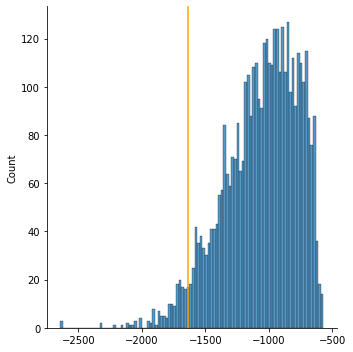

In [ ]:
# Visualize score distributions
# everything to the left of the orange line are classified as anomalies
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(scores, bins=100)
plt.axvline(x=threshold, color='orange')

Unfortunately, the AUC of Gaussian Mixture is worse than K-Means. We suspect that it might be because the model is overfitting on the shape of the cluster.

#### Summary of models, train-test on First Batch only

This is the combined result of our initial model training on the train split of the first batch, validated on the validation split of the first batch.

In [ ]:
combined = pd.concat([result_df1,result_df2,result_df3,result_df4,result_df5,result_df6,result_df7])
combined = combined.sort_values('AUC')
combined

,AUC,Precision,Recall,F1 Score
GMM,0.452000,0.022124,0.125,0.037594
KMM,0.494000,0.026316,0.025,0.025641
CNB,0.557000,0.051829,0.425,0.092391
LR,0.576500,0.145455,0.200,0.168421
SVM,0.605000,0.144737,0.275,0.189655
DTC,0.727000,0.475000,0.475,0.475000
NN,0.894825,0.750000,0.075,0.136364


Out of all these models, the neural network seemed to be performing the best in terms of AUC.

### Applying models, train on batch 1, test on batch 2

When we received the labels of batch 2, we decided to repeat our process to confirm our outcomes. This time, we trained on the entirety of the first batch and evaluated the results on the second batch.

#### Convert First and Second Batch to sparse matrix

In [ ]:
X_train = X_matrix # use the sparse matrix already created 
y_train = y1

X_test = to_sparse_matrix(X2)
X_test[887] = 0.0
X_test[972] = 0.0
X_test[974] = 0.0
X_test[976] = 0.0
X_test = X_test.reindex(sorted(X_test.columns), axis=1)
y_test = y2

display(X_train,y_train)
display(X_test,y_test)

item,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5195,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5196,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5197,4.0,4.0,0.0,3.0,0.0,4.0,4.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,label
user,
0,0
1,0
2,0
3,0
4,0
...,...
5195,0
5196,0
5197,0


item,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user,,,,,,,,,,,,,,,,,,,,,
5200,6.0,4.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,0.0,...,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0
5201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5202,6.0,0.0,4.0,5.0,0.0,4.0,5.0,6.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204,5.0,4.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,2.0,3.0,0.0,0.0,0.0,2.0,0.0,5.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6496,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
6497,6.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


,label
user,
5200,0
5201,1
5202,0
5203,1
5204,0
...,...
6495,0
6496,0
6497,1


#### Applying Naive Bayes Classifier

In [ ]:
cnb = ComplementNB()

cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df1 = pd.DataFrame(result, index=["CNB"])
result_df1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
CNB,0.590167,0.335859,0.443333,0.382184


#### Applying Logistic Regression

In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df2 = pd.DataFrame(result, index=["LR"])
result_df2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
LR,0.558,0.485714,0.17,0.251852


#### Applying SVM

In [ ]:
svm = SVM.SVC(kernel='linear')

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df3 = pd.DataFrame(result, index=["SVM"])
result_df3

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,AUC,Precision,Recall,F1 Score
SVM,0.575167,0.478571,0.223333,0.304545


#### Applying Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy',random_state=5)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df4 = pd.DataFrame(result, index=["DTC"])
result_df4

,AUC,Precision,Recall,F1 Score
DTC,0.749,0.876404,0.52,0.65272


#### Applying Neural Network

In [ ]:
nn = create_nn()

nn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(from_logits=False),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

nn.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
163/163 [==============================] - 2s 4ms/step - loss: 0.1621 - auc_1: 0.7589 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2/5
163/163 [==============================] - 1s 4ms/step - loss: 0.1003 - auc_1: 0.9349 - precision_1: 1.0000 - recall_1: 0.0100
Epoch 3/5
163/163 [==============================] - 1s 4ms/step - loss: 0.0706 - auc_1: 0.9781 - precision_1: 0.9412 - recall_1: 0.1600
Epoch 4/5
163/163 [==============================] - 1s 4ms/step - loss: 0.0476 - auc_1: 0.9912 - precision_1: 0.9570 - recall_1: 0.4450
Epoch 5/5
163/163 [==============================] - 1s 4ms/step - loss: 0.0301 - auc_1: 0.9952 - precision_1: 0.9732 - recall_1: 0.7250


In [ ]:
y_pred = nn.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df5 = pd.DataFrame(result, index=["NN"])
result_df5

41/41 [==============================] - 0s 1ms/step


,AUC,Precision,Recall,F1 Score
NN,0.874657,0.833333,0.1,0.178571


#### Applying Gaussian Mixture Model

In [ ]:
# Create Gaussian Mixture Model & fit it
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=1)
gmm.fit(X_train)

# Get the scores of the train sample
scores = gmm.score_samples(X_train)

# Get proportion of users on train set that are fake
percentile = (y_train['label'].value_counts(normalize=True) * 100)[1] 

# Use it to set a threshold for the scores
threshold = np.percentile(scores, percentile)

# Predict for validation set
scores_pred = gmm.score_samples(X_test)

# Predict labels
y_pred_df = y_test.copy()
y_pred_df['scores'] = scores_pred
y_pred_df['predicted_labels'] = y_pred_df['scores'].apply(lambda x: 1 if x < threshold else 0)
y_pred = y_pred_df['predicted_labels'].to_numpy()

# Evaluate results
result = get_metrics(y_pred, y_test.label)
result_df6 =  pd.DataFrame(result, index=["GMM"])
result_df6

,AUC,Precision,Recall,F1 Score
GMM,0.4895,0.208333,0.15,0.174419


#### Applying KMeans Model

In [ ]:
# Scale Dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train Model
km = KMeans(n_clusters=1)
kmm = km.fit(X_train)

km_labels = kmm.labels_
km_center = kmm.cluster_centers_

# Calculate distances
km_distances = euclidean_dist(X_train, km_center)

# Percentage of Anomalties on Dataset
km_percentile = (y_train['label'].value_counts(normalize=True) * 100)[0]
km_threshold = np.percentile(km_distances, km_percentile)

# Predict Labels
y_pred = y_test.copy()
y_pred['dist'] = euclidean_dist(X_test, km_center)
y_pred['predicted_label'] = y_pred['dist'].apply(lambda x: 1 if x >= km_threshold else 0)
y_pred = y_pred.drop('label', axis=1).drop('dist', axis=1)

result = get_metrics(y_pred.predicted_label.values, y_test)

result_df7= pd.DataFrame(result, index=["KMM"])
result_df7

,AUC,Precision,Recall,F1 Score
KMM,0.4905,0.133333,0.02,0.034783


#### Summary of models, train on First Batch, test on Second Batch

In [ ]:
combined2 = pd.concat([result_df1,result_df2,result_df3,result_df4,result_df5,result_df6,result_df7])
combined2 = combined2.sort_values('AUC')
combined2

,AUC,Precision,Recall,F1 Score
GMM,0.489500,0.208333,0.150000,0.174419
KMM,0.490500,0.133333,0.020000,0.034783
LR,0.558000,0.485714,0.170000,0.251852
SVM,0.575167,0.478571,0.223333,0.304545
CNB,0.590167,0.335859,0.443333,0.382184
DTC,0.749000,0.876404,0.520000,0.652720
NN,0.874657,0.833333,0.100000,0.178571


NN consistently performed better than the rest in terms of AUC.

### Overall summary of Week 9

Here is the summary of all the metrics that we got from Week 9 for easier comparison. There wasn't a significant difference between the performances of the models on the validation set of the first batch compared to the actual test on second batch.

In [ ]:
combined.index.name = ('Train-test on First Batch only')
combined2.index.name = ('Train on First Batch, test on Second Batch')
display(combined, combined2)

,AUC,Precision,Recall,F1 Score
Train-test on First Batch only,,,,
GMM,0.452000,0.022124,0.125,0.037594
KMM,0.494000,0.026316,0.025,0.025641
CNB,0.557000,0.051829,0.425,0.092391
LR,0.576500,0.145455,0.200,0.168421
SVM,0.605000,0.144737,0.275,0.189655
DTC,0.727000,0.475000,0.475,0.475000
NN,0.894825,0.750000,0.075,0.136364


,AUC,Precision,Recall,F1 Score
"Train on First Batch, test on Second Batch",,,,
GMM,0.489500,0.208333,0.150000,0.174419
KMM,0.490500,0.133333,0.020000,0.034783
LR,0.558000,0.485714,0.170000,0.251852
SVM,0.575167,0.478571,0.223333,0.304545
CNB,0.590167,0.335859,0.443333,0.382184
DTC,0.749000,0.876404,0.520000,0.652720
NN,0.874657,0.833333,0.100000,0.178571


## Week 10 (Third Batch)

Reflecting upon our less than satisfactory results in week 9, we decided that sparse matrix representation of our data was probably not the way to go. We surmised that this was because of the curse of dimensionality (we had 1000 features). Additionally, the sparse matrix representation might not contain meaningful information for us to derive the difference between anomalous points and normal points.

Thus, in this week, we decided to use hand-engineered features instead of a sparse matrix for the training set. We hope that the hand-engineered features would give us a more meaningful representation in less dimensions.

### Applying NN, train-test on batch 1 and 2

#### Train-test split

Since we were only in the possession of the first and second batch with labels at this point in time, we decided to combine them.

In [ ]:
X1, y1 = pre_process(data1)
X2, y2 = pre_process(data2)

X_combined = pd.concat([X1,X2])
y_combined = pd.concat([y1,y2])

Then, we did a train-test split on the combined dataset.

In [ ]:
X_train, X_test, y_train, y_test = ttsplit(X_combined, y_combined)

(5200, 1)
(1300, 1)


#### Feature Engineering

We decided to hand-engineer the following features:
1. `rating_counts`: number of movies the user rated

2. `mean_rating_ratio`: the average of the ratio of the user's rating on a movie, against the average rating of that movie
$$
mean\_rating\_ratio_a = \frac{1}{n}\sum_{i=1}^{n}\frac{rating_{a,i}}{rating_{avg,i}}
$$

3. `sq_rating_diff`: difference between the user's rating on a movie, and the average rating of that movie, squared
$$
sq\_rating\_diff_a = \frac{1}{n}\sum_{i=1}^{n}({rating_{a,i}} - {rating_{avg,i}})^2
$$

4. `rating_std`: the standard deviation of the user's ratings
5. `rating_mode`: the mode of the user's ratings
6. `popularity`: the popularity of movies that the user have rated
We wanted to have a metric to capture the popularity of the movies that the user has rated. Fake users might be created to boost the ratings of unpopular movies.
$$
popularity = \frac{1}{n}\sum_{i}^{n}counts_{a,i}
$$

Apply Feature Engineering

In [ ]:
from scipy import stats

def feature_engineer(df):
    """
    This step is encapsulated as a function so that we can apply it to XX_test
    """
    # average rating for each movie
    avg_movie_rating = df.groupby('item').agg({'rating': np.mean}).to_dict()['rating'] 
 
    # number of ratings for each movie
    movie_rating_counts = df.groupby('item').apply(len).to_dict()

    df['avg_rating (per movie)'] = [avg_movie_rating[n] for n in df['item'].to_numpy()]  
    df['rating ratio'] = df['rating'] / df['avg_rating (per movie)']
    df['rating diff'] = np.square(df['rating'] - df['avg_rating (per movie)'])
    
    df['num_ratings (per movie)'] = [movie_rating_counts[n] for n in df['item'].to_numpy()]
    df = df.groupby('user').agg({'item': len, 
                                 'rating ratio': np.mean, 
                                 'rating diff': np.mean, 
                                 'rating': [np.std, lambda n: stats.mode(n)[0]],
                                'num_ratings (per movie)':np.mean})

    # rename
    df.columns = df.columns.to_flat_index()
    cols = df.columns
    new_columns = ['rating_counts', 'mean_rating_ratio', 'sq_rating_diff', 'rating_std', 'rating_mode','popularity']
    rename_map = {old: new_columns[i] for i, old in enumerate(list(cols))}

    df = df.rename(columns=rename_map)
    return df

We apply the feature engineering to the train and test sets separately because we don't want to be including the mean of the test set in the feature engineering of the train set.

In [ ]:
X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)
display(X_train, X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
0,35,1.122314,0.644283,0.847141,4,1520.428571
1,81,1.018930,0.305640,0.654283,4,2017.617284
3,141,0.993181,2.230955,1.479067,4,1459.652482
4,79,0.746577,2.790018,1.525080,4,1664.113924
5,43,1.209360,1.243055,0.973059,5,1562.441860
...,...,...,...,...,...,...
6495,362,0.790759,3.709817,1.748369,1,1348.580110
6496,191,1.035628,0.437093,0.671385,3,1448.523560
6497,79,1.503380,2.793849,0.473237,5,984.113924


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
2,26,0.786146,1.520221,1.079173,2,552.692308
14,21,1.262717,1.086218,0.511766,5,522.761905
16,39,1.068946,0.588258,0.731958,4,453.538462
19,285,1.070576,0.414687,0.751787,4,339.940351
21,148,0.859583,1.052146,1.032720,3,360.108108
...,...,...,...,...,...,...
6469,62,0.305710,5.558903,0.000000,1,399.467742
6475,161,0.949572,0.454405,0.674456,3,338.391304
6478,66,0.852967,0.813988,0.774446,3,446.590909


##### Visualisation

We visualised our feature engineered data to see if it does a better job at discerning important relationships of our data (i.e. make it easier to distinguish anomalies from normal data points).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb685f4f7d0>,
      dtype=object)

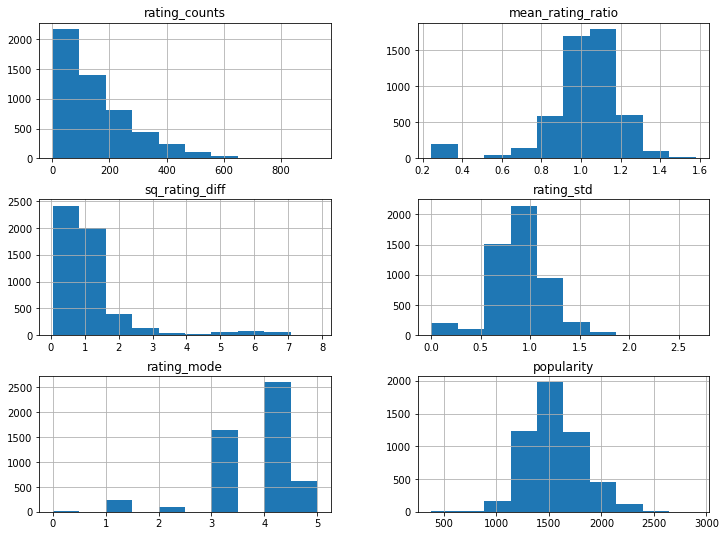

In [ ]:
# histogram

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (12,9))
ax = fig.gca()
X_train.hist(ax=ax)

We also want to make sure that our features are not heavily correlated with each other. This is because heavily correlated features will increase the dimensionality without contributing useful information, thus overcomplicating the model.

Fortunately, from our visualisation, we can see that most of the features are not heavily correlated with each other.

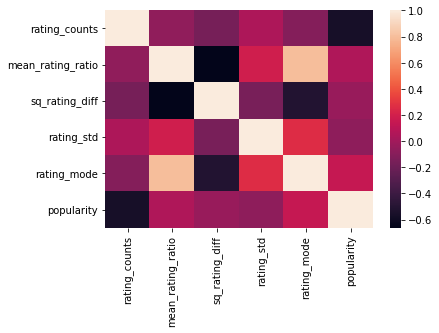

In [ ]:
# correlation matrix

import seaborn as sns

sns.heatmap(X_train.corr(), 
        xticklabels=X_train.columns,
        yticklabels=X_train.columns)

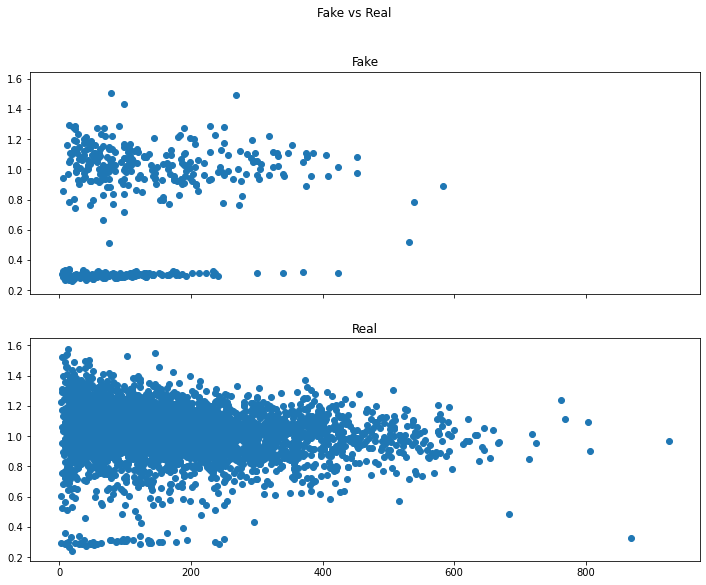

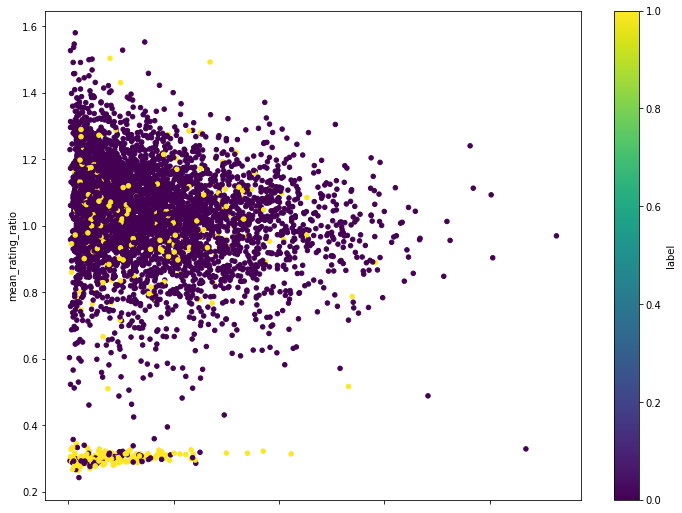

In [ ]:
import matplotlib.pyplot as plt

# visualise fake accounts in 2 dimensions

# choose features here
columns = ['rating_counts', 'mean_rating_ratio']

joined_train = pd.DataFrame(X_train).join(y_train)
fake = joined_train[joined_train['label'] == 1]
real = joined_train[joined_train['label'] == 0]

fig, axs = plt.subplots(2, figsize=(12, 9), sharey=True, sharex=True)
fig.suptitle('Fake vs Real')

fake = fake[columns]
real = real[columns]
axs[0].plot(fake[columns[0]], fake[columns[1]], 'o')
axs[0].set_title("Fake")
axs[1].plot(real[columns[0]], real[columns[1]], 'o')
axs[1].set_title("Real")

joined_train[columns + ['label']].plot.scatter(x=columns[0], y=columns[1], c='label', colormap='viridis', figsize=(12, 9))

In [ ]:
# 3d

import plotly.express as px

fig = px.scatter_3d(joined_train, x='mean_rating_ratio', y='sq_rating_diff', z='popularity',
              color='label', size_max=11, opacity=0.7)
fig.show()

From the visualisations, we can see that the feature engineering made anomalies more discernible. We can clearly see a distribution of anomalies that are extracted away from the main distribution of normal points.

#### Applying NN

Therefore, we tried to train a neural network using the engineered features instead of our original sparse matrix. We modified the architecture a little bit to include more layers and different number of neurons.

In [ ]:
nn = create_nn()
nn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
nn.fit(X_train, y_train, epochs=130, batch_size = 32)

Epoch 1/130
163/163 [==============================] - 2s 4ms/step - loss: 12.4970 - auc_2: 0.4896 - precision_2: 0.0640 - recall_2: 0.0638
Epoch 2/130
163/163 [==============================] - 1s 4ms/step - loss: 4.9696 - auc_2: 0.5078 - precision_2: 0.0916 - recall_2: 0.0898
Epoch 3/130
163/163 [==============================] - 1s 4ms/step - loss: 2.1734 - auc_2: 0.5190 - precision_2: 0.1097 - recall_2: 0.1017
Epoch 4/130
163/163 [==============================] - 1s 4ms/step - loss: 1.0415 - auc_2: 0.5062 - precision_2: 0.0909 - recall_2: 0.0757
Epoch 5/130
163/163 [==============================] - 1s 4ms/step - loss: 0.5604 - auc_2: 0.5349 - precision_2: 0.1134 - recall_2: 0.0520
Epoch 6/130
163/163 [==============================] - 1s 4ms/step - loss: 0.4353 - auc_2: 0.5198 - precision_2: 0.0909 - recall_2: 0.0213
Epoch 7/130
163/163 [==============================] - 1s 4ms/step - loss: 0.3728 - auc_2: 0.5223 - precision_2: 0.1111 - recall_2: 0.0142
Epoch 8/130
163/163 [=====

In [ ]:
y_pred = nn.predict(X_test)
result = get_metrics(y_pred, y_test)

result_df1 = pd.DataFrame(result, index=["NN"])
result_df1

41/41 [==============================] - 0s 1ms/step


,AUC,Precision,Recall,F1 Score
NN,0.781178,1.0,0.40566,0.577181


### Applying NN, train on batch 2. Test on batch 3

Given the knowledge that batch 2 is from the same distribution as batch 3, while batch 1 is from a different distribution, we attempted to train only on batch 2.

In [ ]:
# Initial Pre-processing
X2, y2 = pre_process(data2)
X3, y3 = pre_process(data3)

y2 = y2.set_index('user').sort_index()
y3 = y3.set_index('user').sort_index()

#### Feature Engineering

We applied the same method of feature engineering.

In [ ]:
X_train = feature_engineer(X2)
X_test = feature_engineer(X3)

However, we found that somehow the feature engineering introduced a NaN value, hence we removed it by replacing it with a 0.

In [ ]:
# Detect NaN
train_outlier = X_train[X_train.isna().any(axis=1)]
display(train_outlier)

test_outlier = X_test[X_test.isna().any(axis=1)]
display(test_outlier)

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
6767,1,0.0,12.327044,NaN,0,182.0


In [ ]:
# Edit outlier
X_test.at[6767, 'rating_std'] = 0
display(X_test.loc[6767])

rating_counts          1.000000
mean_rating_ratio      0.000000
sq_rating_diff        12.327044
rating_std             0.000000
rating_mode            0.000000
popularity           182.000000
Name: 6767, dtype: float64

#### Applying NN

Using the same model architecture, we trained a neural network on the second batch only.

In [ ]:
y_train = y2
y_test = y3

nn = create_nn()
nn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
nn.fit(X_train, y_train, epochs=130, batch_size = 32)

Epoch 1/130
41/41 [==============================] - 3s 9ms/step - loss: 11.1784 - auc_3: 0.4983 - precision_3: 0.2412 - recall_3: 0.2500
Epoch 2/130
41/41 [==============================] - 0s 7ms/step - loss: 6.1086 - auc_3: 0.5075 - precision_3: 0.2294 - recall_3: 0.2133
Epoch 3/130
41/41 [==============================] - 0s 7ms/step - loss: 4.2910 - auc_3: 0.5147 - precision_3: 0.2457 - recall_3: 0.2367
Epoch 4/130
41/41 [==============================] - 0s 8ms/step - loss: 3.5315 - auc_3: 0.5235 - precision_3: 0.2432 - recall_3: 0.2367
Epoch 5/130
41/41 [==============================] - 0s 7ms/step - loss: 2.5475 - auc_3: 0.5290 - precision_3: 0.2662 - recall_3: 0.2467
Epoch 6/130
41/41 [==============================] - 0s 9ms/step - loss: 1.9920 - auc_3: 0.5463 - precision_3: 0.2509 - recall_3: 0.2433
Epoch 7/130
41/41 [==============================] - 0s 7ms/step - loss: 1.7913 - auc_3: 0.5192 - precision_3: 0.2383 - recall_3: 0.2033
Epoch 8/130
41/41 [=====================

In [ ]:
y_pred = nn.predict(X_test)

result = get_metrics(y_pred, y_test)

result_df2 = pd.DataFrame(result, index=["NN"])
result_df2

41/41 [==============================] - 0s 1ms/step


,AUC,Precision,Recall,F1 Score
NN,0.763687,0.913043,0.07,0.130031


### Overall summary of Week 10

By using the feature engineering, we saw that our results have improved significantly compared to the previous week, where we used sparse matrix.

In [ ]:
result_df1.index.name = ('Train-test on batch 1 and 2')
result_df2.index.name = ('Train on batch 2, test on batch 3')
display(result_df1, result_df2)

,AUC,Precision,Recall,F1 Score
Train-test on batch 1 and 2,,,,
NN,0.781178,1.0,0.40566,0.577181


,AUC,Precision,Recall,F1 Score
"Train on batch 2, test on batch 3",,,,
NN,0.763687,0.913043,0.07,0.130031


## Week 11 (Fourth Batch)

### Unsupervised Learning with Feature Engineering

Considering how the feature engineering seemed to introduce the concept of a separate cluster / distribution for anomalies, we decided to give unsupervised learning (i.e. K-Means and Gaussian Mixture) another shot. We hoped that they would perform better this time.

In [ ]:
# Prepare Training Data
X1, y1 = pre_process(data1)
X2, y2 = pre_process(data2)
X3, y3 = pre_process(data3)

y1 = y1.set_index('user').sort_index()
y2 = y2.set_index('user').sort_index()
y3 = y3.set_index('user').sort_index()

X=pd.concat([X1,X2])
y=pd.concat([y1,y2])

# Apply feature engineering
X_train = feature_engineer(X)

y_train = y.copy()

display(X_train)
display(y_train)

# Remove NaNs
# X_train = X_train['rating_std'].fillna(0)

# Prepare Testing Data
# Apply feature engineering
X_test = feature_engineer(X3)

# Remove NaNs
# X_test = X_test['rating_std'].fillna(0)

y_test = y3.copy()

display(X_test)
display(y_test)

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
0,35,1.121770,0.645320,0.847141,4,1888.142857
1,81,1.019743,0.308932,0.654283,4,2507.037037
2,26,0.784152,1.538164,1.079173,2,2802.653846
3,141,0.994803,2.229617,1.479067,4,1814.936170
4,79,0.747895,2.784877,1.525080,4,2064.025316
...,...,...,...,...,...,...
6495,362,0.791390,3.712928,1.748369,1,1674.080110
6496,191,1.036567,0.434475,0.671385,3,1801.670157
6497,79,1.505204,2.811870,0.473237,5,1219.620253


,label
user,
0,0
1,0
2,0
3,0
4,0
...,...
6495,0
6496,0
6497,1


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
6500,61,1.154425,0.754910,0.822498,4,402.934426
6501,67,1.040134,0.595407,0.910514,4,387.985075
6502,72,1.073630,0.765086,0.931852,3,429.250000
6503,276,1.063443,0.302642,0.593642,3,327.293478
6504,48,0.729256,2.947873,1.463504,3,462.000000
...,...,...,...,...,...,...
7795,138,1.148944,0.658787,0.721766,4,475.898551
7796,120,1.137559,0.728055,0.784969,4,393.433333
7797,140,0.668484,3.423348,1.558651,3,404.335714


,label
user,
6500,0
6501,0
6502,0
6503,0
6504,0
...,...
7795,0
7796,0
7797,0


In [ ]:
# Detect NaN
train_outlier = X_train[X_train.isna().any(axis=1)]
display(train_outlier)

test_outlier = X_test[X_test.isna().any(axis=1)]
display(test_outlier)

# Edit outlier
X_test.at[6767, 'rating_std'] = 0
display(X_test.loc[6767])

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
6767,1,0.0,12.327044,NaN,0,182.0


rating_counts          1.000000
mean_rating_ratio      0.000000
sq_rating_diff        12.327044
rating_std             0.000000
rating_mode            0.000000
popularity           182.000000
Name: 6767, dtype: float64

#### Apply KMeans Model

In [ ]:
# Scale Dataset
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train Model
km = KMeans(n_clusters=1)
kmm = km.fit(X_train)

km_labels = kmm.labels_
km_center = kmm.cluster_centers_

# Calculate distances
km_distances = euclidean_dist(X_train, km_center)

# Percentage of Anomalties on Dataset
km_percentile = (y_train['label'].value_counts(normalize=True) * 100)[0]
km_threshold = np.percentile(km_distances, km_percentile)

# Predict Labels
y_pred = y_test.copy()
y_pred['dist'] = euclidean_dist(X_test, km_center)
y_pred['predicted_label'] = y_pred['dist'].apply(lambda x: 1 if x >= km_threshold else 0)
y_pred = y_pred.drop('label', axis=1).drop('dist', axis=1)

result = get_metrics(y_pred.to_numpy(), y_test)

result_df= pd.DataFrame(result, index=["KMM"])
result_df

,AUC,Precision,Recall,F1 Score
KMM,0.5,0.230769,1.0,0.375


The result is better than the sparse matrix, with a high recall. However, the AUC is still equivalent to classifying samples randomly.

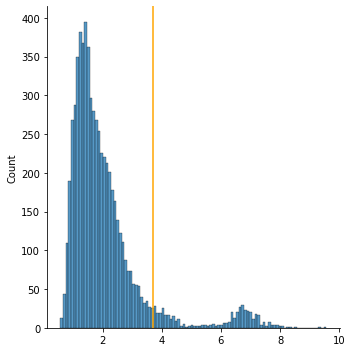

In [ ]:
# Display distribution of data points from center
import seaborn as sns
sns.displot(km_distances, bins=100)
plt.axvline(x=km_threshold, color='orange')

The distribution of data points from the centroid have changed a bit. There now seems to be a new cluster of points that are located far from the main cluster where most of the points are, which we predict are probably the anomalies.

#### Apply Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
# Create Gaussian Mixture Model & fit it
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=1)
gmm.fit(X_train)

# Get the scores of the train sample
scores = gmm.score_samples(X_train)

# Get proportion of users on train set that are fake
percentile = (y_train['label'].value_counts(normalize=True) * 100)[1] 

# Use it to set a threshold for the scores
threshold = np.percentile(scores, percentile)

# Predict for validation set
scores_pred = gmm.score_samples(X_test)

# Predict labels
y_pred_df = y_test.copy()
y_pred_df['scores'] = scores_pred
y_pred_df['predicted_labels'] = y_pred_df['scores'].apply(lambda x: 1 if x < threshold else 0)
y_pred = y_pred_df['predicted_labels'].to_numpy()

# Evaluate results
result = get_metrics(y_pred, y_test.label)
result_df =  pd.DataFrame(result, index=["GMM"])
result_df

,AUC,Precision,Recall,F1 Score
GMM,0.5,0.230769,1.0,0.375


Like the KMeans model, the result is better than the sparse matrix, with a high recall. However, the AUC is also equivalent to classifying samples randomly.

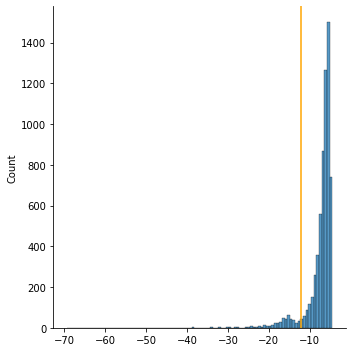

In [ ]:
import seaborn as sns
sns.displot(scores, bins=100)
plt.axvline(x=threshold, color='orange')

We also see a better separation of points in the distribution, with most points falling on the large cluster.

### Applying NN, train-test on batch 1,2 and 3

Since we have batches 1, 2, and 3, we decided to combine the datasets and perform a train-test split for this week's model evaluation.

Combine datasets

In [ ]:
X1, y1 = pre_process(data1)
X2, y2 = pre_process(data2)
X3, y3 = pre_process(data3)

X_combined = pd.concat([X1,X2,X3])
y_combined = pd.concat([y1,y2,y3])

#### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = ttsplit(X_combined, y_combined)

(6240, 1)
(1560, 1)


#### Feature Engineering with normalisation

For our feature engineering, we added log normalisation to `rating_counts` and `sq_rating_diff`.

In [ ]:
from scipy import stats

def feature_engineer2(df):
    """
    This step is encapsulated as a function so that we can apply it to XX_test
    """
    # average rating for each movie
    avg_movie_rating = df.groupby('item').agg({'rating': np.mean}).to_dict()['rating'] 
 
    # number of ratings for each movie
    movie_rating_counts = df.groupby('item').apply(len).to_dict()

    df['avg_rating (per movie)'] = [avg_movie_rating[n] for n in df['item'].to_numpy()]  
    df['rating ratio'] = df['rating'] / df['avg_rating (per movie)']
    df['rating diff'] = np.square(df['rating'] - df['avg_rating (per movie)'])
    
    df['num_ratings (per movie)'] = [movie_rating_counts[n] for n in df['item'].to_numpy()]
    df = df.groupby('user').agg({'item': len, 
                                 'rating ratio': np.mean, 
                                 'rating diff': np.mean, 
                                 'rating': [np.std, lambda n: stats.mode(n)[0]],
                                'num_ratings (per movie)':np.mean})

    # rename
    df.columns = df.columns.to_flat_index()
    cols = df.columns
    new_columns = ['rating_counts', 'mean_rating_ratio', 'sq_rating_diff', 'rating_std', 'rating_mode','popularity']
    rename_map = {old: new_columns[i] for i, old in enumerate(list(cols))}

    df = df.rename(columns=rename_map)

    # apply log to non-normal features
    df['rating_counts'] = df['rating_counts'].apply(np.log)
    df['sq_rating_diff'] = df['sq_rating_diff'].apply(np.log)

    return df

In [ ]:
X_train = feature_engineer2(X_train)
X_test = feature_engineer2(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

We also added normalisation via a standard scaler, which we fitted on only the train set and used to transform both the train and test sets respectively.

In [ ]:
# Apply scaling
from sklearn.preprocessing import StandardScaler
new_columns = ['rating_counts', 'mean_rating_ratio', 'sq_rating_diff', 'rating_std', 'rating_mode','popularity']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns=new_columns,index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test),columns=new_columns,index=X_test.index)

Remove Nans

Again, we remove any NaN values that were introduced in the feature engineering.

In [ ]:
train_outlier = X_train[X_train.isna().any(axis=1)]
display(train_outlier)

test_outlier = X_test[X_test.isna().any(axis=1)]
display(test_outlier)

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
6767,-4.895109,-5.207574,3.969649,NaN,-3.817283,-3.098546


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,


In [ ]:
# Edit outlier
X_train.at[6767, 'rating_std'] = 0
display(X_train.loc[6767])

rating_counts       -4.895109
mean_rating_ratio   -5.207574
sq_rating_diff       3.969649
rating_std           0.000000
rating_mode         -3.817283
popularity          -3.098546
Name: 6767, dtype: float64

#### Applying NN

We implemented early stopping. Early stopping works by terminating the training when loss stops changing significantly. We hoped that it would reduce the chance of overfitting.

In [ ]:
nn = create_nn()
nn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
nn.fit(X_train, y_train, epochs=128, callbacks=[early_stopping])

Epoch 1/128
195/195 [==============================] - 2s 4ms/step - loss: 0.3483 - auc_4: 0.6198 - precision_4: 0.4839 - recall_4: 0.0906
Epoch 2/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3141 - auc_4: 0.6682 - precision_4: 0.6346 - recall_4: 0.1495
Epoch 3/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3128 - auc_4: 0.6781 - precision_4: 0.5610 - recall_4: 0.1042
Epoch 4/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3095 - auc_4: 0.6839 - precision_4: 0.5909 - recall_4: 0.1375
Epoch 5/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3084 - auc_4: 0.6807 - precision_4: 0.6233 - recall_4: 0.1375
Epoch 6/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3068 - auc_4: 0.6913 - precision_4: 0.6133 - recall_4: 0.1390
Epoch 7/128
195/195 [==============================] - 1s 4ms/step - loss: 0.3056 - auc_4: 0.6899 - precision_4: 0.6194 - recall_4: 0.1450
Epoch 8/128
195/195 [======

In [ ]:
y_pred = nn.predict(X_test)

result = get_metrics(y_pred, y_test)

result_df1 = pd.DataFrame(result, index=["NN"])
result_df1

49/49 [==============================] - 0s 3ms/step


,AUC,Precision,Recall,F1 Score
NN,0.611513,0.811321,0.265432,0.4


### Applying NN, train on batch 2,3. Test on batch 4.

We tried to remove batch 1 from the training process, following the same process as before.

##### Combine datasets & import batch 4

In [ ]:
X2, y2 = pre_process(data2)
X3, y3 = pre_process(data3)

X_combined = pd.concat([X2,X3])
y_combined = pd.concat([y2,y3])

X4, y4 = pre_process(data4)

X_train = X_combined
y_train = y_combined
X_test = X4
y_test = y4

y_train = y_train.set_index('user').sort_index()
y_test = y_test.set_index('user').sort_index()

#### Feature Engineering with normalisation

In [ ]:
X_train = feature_engineer2(X_train)
X_test = feature_engineer2(X_test)

In [ ]:
# Apply scaling
from sklearn.preprocessing import StandardScaler
new_columns = ['rating_counts', 'mean_rating_ratio', 'sq_rating_diff', 'rating_std', 'rating_mode','popularity']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns=new_columns,index=X_train.index)

X_test = pd.DataFrame(scaler.transform(X_test),columns=new_columns,index=X_test.index)

Remove NaNs

In [ ]:
train_outlier = X_train[X_train.isna().any(axis=1)]
display(train_outlier)

test_outlier = X_test[X_test.isna().any(axis=1)]
display(test_outlier)

,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,
6767,-4.882,-4.335524,3.445734,NaN,-3.216346,-3.20647


,rating_counts,mean_rating_ratio,sq_rating_diff,rating_std,rating_mode,popularity
user,,,,,,


In [ ]:
# Edit outlier
X_train.at[6767, 'rating_std'] = 0
display(X_train.loc[6767])

rating_counts       -4.882000
mean_rating_ratio   -4.335524
sq_rating_diff       3.445734
rating_std           0.000000
rating_mode         -3.216346
popularity          -3.206470
Name: 6767, dtype: float64

#### Applying NN

In [ ]:
nn = create_nn()
nn.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.AUC(from_logits=False),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
nn.fit(X_train, y_train, epochs=128, callbacks=[early_stopping])

Epoch 1/128
82/82 [==============================] - 1s 4ms/step - loss: 0.4621 - auc_5: 0.7535 - precision_5: 0.6803 - recall_5: 0.3617
Epoch 2/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3701 - auc_5: 0.8330 - precision_5: 0.8299 - recall_5: 0.4633
Epoch 3/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3623 - auc_5: 0.8473 - precision_5: 0.8249 - recall_5: 0.4633
Epoch 4/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3418 - auc_5: 0.8651 - precision_5: 0.8499 - recall_5: 0.5000
Epoch 5/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3397 - auc_5: 0.8670 - precision_5: 0.8300 - recall_5: 0.4883
Epoch 6/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3344 - auc_5: 0.8744 - precision_5: 0.8709 - recall_5: 0.4833
Epoch 7/128
82/82 [==============================] - 0s 4ms/step - loss: 0.3262 - auc_5: 0.8820 - precision_5: 0.8659 - recall_5: 0.4950
Epoch 8/128
82/82 [======================

In [ ]:
y_pred = nn.predict(X_test)

result = get_metrics(y_pred, y_test)

result_df2 = pd.DataFrame(result, index=["NN"])
result_df2

41/41 [==============================] - 0s 2ms/step


,AUC,Precision,Recall,F1 Score
NN,0.652353,0.308219,0.6,0.40724


### Overall Summary of Week 11


In [ ]:
result_df1.index.name = ('Train-test on batch 1,2 and 3')
result_df2.index.name = ('Train on batch 2,3. Test on batch 4')
display(result_df1, result_df2)

,AUC,Precision,Recall,F1 Score
"Train-test on batch 1,2 and 3",,,,
NN,0.611513,0.811321,0.265432,0.4


,AUC,Precision,Recall,F1 Score
"Train on batch 2,3. Test on batch 4",,,,
NN,0.652353,0.308219,0.6,0.40724


## Week 12 (Fifth Batch)

After our models' tragic performance in the previous week, we knew we had to do something to improve it. Hence, we tried several techniques in hopes of improving our model. We thought that the problem might lie in the feature representation once more, so we decided to tune the feature representation using autoencoding and feature selection.

#### Autoencoding, train on batch 3 and test on 4

##### Combine datasets

In [ ]:
X3, y3 = pre_process(data3)
X4, y4 = pre_process(data4)

##### Train-test split

In [ ]:
X_train = X3 
X_test = X4
y_train = y3.set_index('user').sort_index()
y_test = y4.set_index('user').sort_index()


print(X_train.shape)
print(X_test.shape)

(195413, 3)
(196796, 3)


##### Feature Engineering with updated features

We added two more features:
- `std_rating_ratio`: standard deviation of rating ratio. Addresses the problem in mean_rating_ratio where a user could have almost as many low ratings as high ratings and the mean could be the same.
$$
std\_rating\_ratio = σ(\frac{rating_{a,i}}{rating_{avg,i}})
$$
- `std_sq_rating_diff`: standard deviation of the square difference of the rating with the average rating
$$
std\_sq\_rating\_diff = σ(({rating_{a,i}} - {rating_{avg,i}})^2)
$$

In [ ]:
from scipy import stats

def feature_engineer(df, scaler=None):
  """
  This step is encapsulated as a function so that we can apply it to XX_test
  """
  # average rating for each movie
  avg_movie_rating = df.groupby('item').agg({'rating': np.mean}).to_dict()['rating'] 

  # number of ratings for each movie (not used yet)
  # movie_rating_counts = df.groupby('item').apply(len).to_dict()

  df['avg_rating (per movie)'] = [avg_movie_rating[n] for n in df['item'].to_numpy()]
  df['rating ratio'] = df['rating'] / df['avg_rating (per movie)']
  df['rating diff'] = np.square(df['rating'] - df['avg_rating (per movie)'])
  # df['num_ratings (per movie)'] = [movie_rating_counts[n] for n in df['item'].to_numpy()]
  df = df.groupby('user').agg({'item': len, 
                                'rating ratio': [np.mean, np.std], 
                                'rating diff': [np.mean, np.std], 
                                'rating': [np.std, lambda n: stats.mode(n)[0]]})

  # rename
  df.columns = df.columns.to_flat_index()
  cols = df.columns
  new_columns = ['rating_counts', 'mean_rating_ratio', 'std_rating_ratio', 'sq_rating_diff', 'std_sq_rating_diff', 'rating_std', 'rating_mode']
  rename_map = {old: new_columns[i] for i, old in enumerate(list(cols))}

  df = df.rename(columns=rename_map)

  # apply log to non-normal features
  df['rating_counts'] = df['rating_counts'].apply(np.log)
  df['sq_rating_diff'] = df['sq_rating_diff'].apply(np.log)
  df['std_rating_ratio'] = df['std_rating_ratio'].apply(np.log)
  df['std_sq_rating_diff'] = df['std_sq_rating_diff'].apply(np.log)

  return df

In [ ]:
X_train = feature_engineer(X_train)
remove_outlier(X_train)
X_test = feature_engineer(X_test)
remove_outlier(X_test)

##### Perform autoencoding

**Create autoencoder model**

We created an autoencoder model consisting of 4 layers. Because we have 7 columns, we want to reduce the representation to a smaller number of dimensions (3).

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 3 # Chosing a dimension for our low-dimensional representation of the data

# This is a placeholder for our input
input = keras.Input(shape=(7,))
intermediate = layers.Dense(32, activation='relu')(input)
# "encoded" is the encoded representation of the input, which we can define by applying a function/layer to the input 
encoded = layers.Dense(encoding_dim, activation='relu')(intermediate)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(7, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction.
autoencoder = keras.Model(input, decoded)
# This model uses the intermediary layer to create a lower-dimensional representation.
encoder = keras.Model(input, encoded)

**Scale the data**

We scaled the data using `MinMaxScaler` to ensure that the values are between 0 and 1.

In [ ]:
# scale data
from sklearn.preprocessing import MinMaxScaler

t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

**Training the model**

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  

autoencoder.fit(X_train, X_train,
                epochs=50, 
                batch_size=256, 
                shuffle=True, 
                validation_data=(X_test, X_test))  # we are not using the validation set to make any decisions

Epoch 1/50
6/6 [==============================] - 1s 29ms/step - loss: 0.6503 - val_loss: 0.6494
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 0.6497 - val_loss: 0.6488
Epoch 3/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6491 - val_loss: 0.6482
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6484 - val_loss: 0.6476
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6479 - val_loss: 0.6470
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6473 - val_loss: 0.6464
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.6467 - val_loss: 0.6458
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6461 - val_loss: 0.6452
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6456 - val_loss: 0.6447
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6450 - val_loss: 0.6441
Epoch 11/50
6/6 [=================

**Comparing decoded results of test with actual test**

To visualise the encoding, we decided to plot the original data compared with the result of the decoding.

1300/1300 [==============================] - 2s 1ms/step


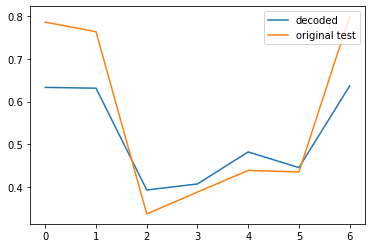

In [ ]:
import matplotlib.pyplot as plt
decoded_results = autoencoder.predict(X_test, batch_size=1)
plt.plot(decoded_results[0], label='decoded')
plt.plot(X_test[0], label='original test')
plt.legend(loc=1)

Although the decoded result showed that it was lossy to some extent, it still somewhat follows the original. Therefore, we thought that this lower dimensional representation will still do well when used for model training.

**Creating encoded features**

In [ ]:
features_train=encoder(X_train)
features_test=encoder(X_test) 

##### Using autoencoded features on **Logistic Regression**

We evaluated the autoencoding on logistic regression as a baseline.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(features_train,y_train)
yy_pred=lr.predict(features_test)

# Evaluation
from sklearn import metrics
result = {
    'AUC': 0,
    'Precision': 0,
    'Recall': 0,
    'F1 Score': 0
}

# AUC
result['AUC'] = metrics.roc_auc_score(y_train,yy_pred)
# Precision
result['Precision'] = metrics.precision_score(y_train,yy_pred, average='binary')
# Recall
result['Recall'] = metrics.recall_score(y_train,yy_pred, average='binary')
# F1 Score
result['F1 Score'] = metrics.f1_score(y_train,yy_pred, average='binary')

result = pd.DataFrame(result, index=["Metrics"])
result

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



,AUC,Precision,Recall,F1 Score
Metrics,0.507333,0.248677,0.156667,0.192229


##### Using autoencoded features on **Neural Network**

We also tried to evaluate the autoencoding on the same NN architecture that we used previously.

In [ ]:
import tensorflow as tf
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(from_logits=False),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [ ]:
model.fit(features_train, y_train.label, epochs=130, batch_size=32)

test_loss, test_auc, test_prec, test_recall = model.evaluate(features_test, y_test.label, batch_size=1)
test_f1 = 2 * test_prec * test_recall / (test_prec + test_recall)

result = {
    'AUC': test_auc,
    'Precision': test_prec,
    'Recall': test_recall,
    'F1 Score': test_f1
}

result = pd.DataFrame(result, index=["Metrics"])
result

Epoch 1/130
41/41 [==============================] - 1s 4ms/step - loss: 0.5954 - auc_6: 0.5567 - precision_6: 0.6875 - recall_6: 0.1833
Epoch 2/130
41/41 [==============================] - 0s 5ms/step - loss: 0.4284 - auc_6: 0.7483 - precision_6: 0.7765 - recall_6: 0.4400
Epoch 3/130
41/41 [==============================] - 0s 6ms/step - loss: 0.4230 - auc_6: 0.7705 - precision_6: 0.7486 - recall_6: 0.4367
Epoch 4/130
41/41 [==============================] - 0s 6ms/step - loss: 0.4169 - auc_6: 0.7800 - precision_6: 0.7514 - recall_6: 0.4433
Epoch 5/130
41/41 [==============================] - 0s 6ms/step - loss: 0.4168 - auc_6: 0.7710 - precision_6: 0.7433 - recall_6: 0.4633
Epoch 6/130
41/41 [==============================] - 0s 9ms/step - loss: 0.4125 - auc_6: 0.7748 - precision_6: 0.7778 - recall_6: 0.4667
Epoch 7/130
41/41 [==============================] - 0s 9ms/step - loss: 0.4091 - auc_6: 0.7736 - precision_6: 0.7819 - recall_6: 0.4900
Epoch 8/130
41/41 [======================

,AUC,Precision,Recall,F1 Score
Metrics,0.784413,0.855346,0.453333,0.592593


However, we decided not to use autoencoding because it doesn't lead to any significant improvements.

#### Validation split to select features


Instead of trying to encode our data to a lower dimensional model, we looked at selecting the correct features to both reduce our number of dimensions and train the model on only significant information (so that it does not get confused by irrelevant data).

Pre-processing


In [ ]:
X3, y3 = pre_process(data3)
X4, y4 = pre_process(data4)
XX34=pd.concat([X3,X4])
yy34=pd.concat([y3,y4])

##### Train-test split

In [ ]:
XX_train, XX_test, yy_train, yy_test = ttsplit(XX34,yy34)

(2080, 1)
(520, 1)


##### Feature Engineer with Normalisation

In [ ]:
# Feature Enginneering with updated features
XX_train= feature_engineer(XX_train)
XX_test = feature_engineer(XX_test)
remove_outlier(XX_train)
remove_outlier(XX_test)

scaler = StandardScaler().fit(XX_train)
XX_train = scaler.transform(XX_train)
XX_test = scaler.transform(XX_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

##### Validation set to find best subset of features on Neural Network
##### The code to run the validation split takes quite some time (~15 minutes for 7 columns), the output being originally shown is the run which includes all the columns. Please follow the comments in the code if you want to run the validation.

In [ ]:
def drop_features(df,featureList):
    for feature in featureList:
        df = df.drop(columns=feature) 
        
    return df

best_auc = 0
best_droppedFeatures = []
best_model = 0

existing_columns = ['rating_counts', 'mean_rating_ratio', 'std_rating_ratio', 'sq_rating_diff', 
               'std_sq_rating_diff', 'rating_std', 'rating_mode']

# for i in range(len(existing_columns)): #Uncomment this line and comment the next line to test EVERY single combination. WHICH WILL TAKE A WHILE
for i in range(1): #range(1) which will use all columns and run once (Fast)

    #creates a list of tuples which includes the features to drop in this iteration
    feature_toDrop = list(itertools.combinations(existing_columns,i))
    
    for featureList in feature_toDrop:
        #features are dropped from train and validation set 
        XX_train_dropFeat = drop_features(XX_train,featureList)
        XX_test_dropFeat = drop_features(XX_test,featureList)
        
        #display(XX_train_dropFeat.head())
        
        #create a new model for each iteration
        new_model = keras.Sequential([
            keras.layers.Dense(64, activation=tf.nn.relu),
            keras.layers.Dropout(0.2),
            
            keras.layers.Dense(128, activation=tf.nn.relu),  
            keras.layers.Dropout(0.2),
            
            keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])

        new_model.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      metrics=[tf.keras.metrics.AUC(from_logits=False),
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall()])
        
        #early stopping for speed purposes
        new_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        
        #fit on train df with dropped features
        new_model.fit(XX_train_dropFeat, yy_train, epochs=64, callbacks=[new_early_stopping])
        #evaluate on validation df with dropped features
        test_loss, test_auc, test_prec, test_recall = new_model.evaluate(XX_test_dropFeat, yy_test, batch_size = 1)
        
        #update only if auc is better
        if test_auc > best_auc:
            best_auc = test_auc
            best_droppedFeatures = featureList
            best_model = new_model
        print("------------------------------")
    


Epoch 1/64
65/65 [==============================] - 1s 4ms/step - loss: 0.5681 - auc_7: 0.5989 - precision_7: 0.3205 - recall_7: 0.1572
Epoch 2/64
65/65 [==============================] - 0s 4ms/step - loss: 0.5070 - auc_7: 0.6748 - precision_7: 0.6058 - recall_7: 0.1740
Epoch 3/64
65/65 [==============================] - 0s 4ms/step - loss: 0.4977 - auc_7: 0.6809 - precision_7: 0.5969 - recall_7: 0.2390
Epoch 4/64
65/65 [==============================] - 0s 4ms/step - loss: 0.4965 - auc_7: 0.6872 - precision_7: 0.5808 - recall_7: 0.2034
Epoch 5/64
65/65 [==============================] - 0s 4ms/step - loss: 0.4867 - auc_7: 0.6968 - precision_7: 0.6339 - recall_7: 0.2432
Epoch 6/64
65/65 [==============================] - 0s 4ms/step - loss: 0.4849 - auc_7: 0.7059 - precision_7: 0.6225 - recall_7: 0.2662
Epoch 7/64
65/65 [==============================] - 0s 4ms/step - loss: 0.4896 - auc_7: 0.6893 - precision_7: 0.5899 - recall_7: 0.2201
Epoch 8/64
65/65 [==============================

From the validation process, we decided to drop `std_rating_ratio`, `rating_std`, and `popularity` because the combination of the remaining five features performed better.

##### AUC after dropping the features

In [ ]:
print('Best AUC:', best_auc)
# print('Best df:')
# display(drop_features(XX_train,best_droppedFeatures).head())

Best AUC: 0.8227291107177734


#### Final Result

We went back to using the model we used last week.

##### Pre-process

In [ ]:
X3, y3 = pre_process(data3)
X4, y4 = pre_process(data4)
XX34=pd.concat([X3,X4])
yy34=pd.concat([y3,y4])

##### Train-test split

In [ ]:
XX_train, XX_val, yy_train, yy_val = ttsplit(XX34,yy34, test_size=0.33, random_state=6969)

(1742, 1)
(858, 1)


In [ ]:
#Feature Enginneering with updated features
from sklearn.preprocessing import StandardScaler

XX_train= feature_engineer(XX_train)
XX_val = feature_engineer(XX_val)
remove_outlier(XX_train)
remove_outlier(XX_val)

scaler = StandardScaler().fit(XX_train)
XX_train = scaler.transform(XX_train)
XX_val = scaler.transform(XX_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
#set up layers
final_model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=tf.nn.relu),  # Having multiple dense layers of varying size doesnt affect
                                                    # significantly (like 0.01-0.02 diff)
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    # keras.layers.Dense(2, activation=tf.nn.softmax), # Final has to be 2 because 2 categories
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

final_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(from_logits=False),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [ ]:
final_model.fit(XX_train, yy_train, epochs=130, batch_size=32)

test_loss, test_auc, test_prec, test_recall = final_model.evaluate(XX_val, yy_val, batch_size=1)
print('Test AUC:', test_auc)
print('Test Precision:', test_prec)
print('Test Recall:', test_recall)
test_f1 = 2 * test_prec * test_recall / (test_prec + test_recall)
print('Test F1 Score:', test_f1)

Epoch 1/130
55/55 [==============================] - 3s 5ms/step - loss: 0.5375 - auc_8: 0.6502 - precision_8: 0.5141 - recall_8: 0.1802
Epoch 2/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4870 - auc_8: 0.7068 - precision_8: 0.6383 - recall_8: 0.2963
Epoch 3/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4749 - auc_8: 0.7222 - precision_8: 0.6682 - recall_8: 0.3531
Epoch 4/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4789 - auc_8: 0.7211 - precision_8: 0.6146 - recall_8: 0.3111
Epoch 5/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4649 - auc_8: 0.7377 - precision_8: 0.6796 - recall_8: 0.3457
Epoch 6/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4654 - auc_8: 0.7392 - precision_8: 0.6700 - recall_8: 0.3358
Epoch 7/130
55/55 [==============================] - 0s 4ms/step - loss: 0.4599 - auc_8: 0.7502 - precision_8: 0.6889 - recall_8: 0.3827
Epoch 8/130
55/55 [======================

## Reflections

From this project, we learned several things:

1. Curse of dimensionality\
Our sparse matrix representation was not good because it has too many dimensions. We have to try to get a smaller, more meaningful representation.

2. Supervised vs. Unsupervised Learning\
We learned that unsupervised learning is only good when your "anomalies" can be represented in such a way that it deviates from a distribution where all the "normal" points are. In situations like this when we cannot create a feature representation that extracts the anomalies away, supervised learning would work better.

3. Feature Selection\
Selecting features are important because some features may serve to confuse the model more.

4. Importance of Data Visualization\
Data visualization helps us curate the data into an easily understandable format, highlighting useful information such as trends and outliers. As such, it is to do proper exploratory data analysis (EDA) to get a good sense of the data and figure out what kind of models might work well for the problem at hand.

